In [1]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

2024-01-31 14:00:06,193 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'totalBandwidth'),
                           ('ihave', 'gossipBandwidth'),
                           ('iwant', 'gossipBandwidth'),
                           ('gossipBandwidth', 'totalBandwidth'),
                           ('messageReceived', 'messageBandwidth'),
                           ('messageBandwidth', 'totalBandwidth')
                         ])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [4]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../consolidated5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# consolidated = consolidated.diff().dropna()

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
#                   'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
0,1856.745902,3748.0,520.0,0.0,0.0,0.0,0.0,104.2,1702.4,848.6,8,6,12,4,8,2,0.25,1.0,0
1,1722.702500,4936.0,673.0,0.0,0.0,0.0,698.0,135.6,2304.0,1181.2,8,6,12,4,8,2,0.25,1.0,0
2,1779.995058,8457.0,1156.0,0.0,0.0,0.0,689.0,231.6,3896.8,1973.8,8,6,12,4,8,2,0.25,1.0,0
3,2357.267894,7681.0,1032.0,0.0,0.0,0.0,343.0,208.4,3514.6,1770.0,8,6,12,4,8,2,0.25,1.0,0
4,1779.471396,5874.0,796.0,0.0,0.0,0.0,695.0,160.4,2726.0,1390.8,8,6,12,4,8,2,0.25,1.0,0
5,1763.668550,7815.0,1078.0,0.0,0.0,0.0,644.0,216.0,3610.0,1831.0,8,6,12,4,8,2,0.25,1.0,0
6,1876.800830,6706.0,928.0,0.0,0.0,0.0,324.0,186.4,3074.4,1546.8,8,6,12,4,8,2,0.25,1.0,0
7,1663.212644,7044.0,970.0,0.0,0.0,0.0,639.0,195.4,3255.2,1651.0,8,6,12,4,8,2,0.25,1.0,0
8,1953.664855,8019.0,1105.0,0.0,0.0,2.0,648.0,221.4,3700.4,1875.2,8,6,12,4,8,2,0.25,1.0,0
9,1967.343035,5974.0,825.0,0.0,0.0,0.0,320.0,165.8,2744.4,1383.8,8,6,12,4,8,2,0.25,1.0,0


In [5]:
#Differenting -> https://medium.com/@nathanvenos/time-series-analysis-in-python-ab582dd803cd

consolidateddiff = consolidated.diff().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidateddiff.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
1,-134.043402,1188.0,153.0,0.0,0.0,0.0,698.0,31.4,601.6,332.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57.292558,3521.0,483.0,0.0,0.0,0.0,-9.0,96.0,1592.8,792.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,577.272836,-776.0,-124.0,0.0,0.0,0.0,-346.0,-23.2,-382.2,-203.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-577.796498,-1807.0,-236.0,0.0,0.0,0.0,352.0,-48.0,-788.6,-379.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-15.802846,1941.0,282.0,0.0,0.0,0.0,-51.0,55.6,884.0,440.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,113.132280,-1109.0,-150.0,0.0,0.0,0.0,-320.0,-29.6,-535.6,-284.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-213.588186,338.0,42.0,0.0,0.0,0.0,315.0,9.0,180.8,104.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,290.452211,975.0,135.0,0.0,0.0,2.0,9.0,26.0,445.2,224.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,13.678180,-2045.0,-280.0,0.0,0.0,-2.0,-328.0,-55.6,-956.0,-491.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,167.347033,2225.0,300.0,0.0,0.0,0.0,320.0,60.6,1035.6,530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


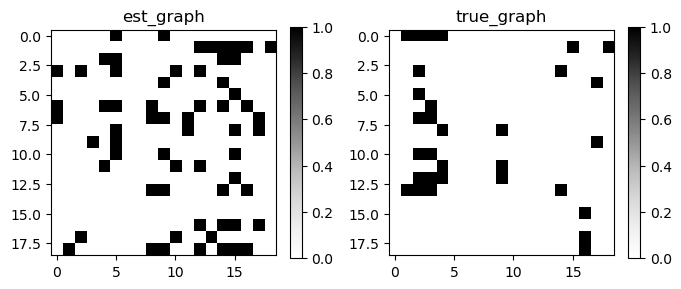

{'fdr': 0.9032, 'tpr': 0.1935, 'fpr': 0.4, 'shd': 74, 'nnz': 62, 'precision': 0.0952, 'recall': 0.1935, 'F1': 0.1277, 'gscore': 0.0}


In [11]:
# structure learning
# priori = PrioriKnowledge(X.shape[1])
# priori.add_forbidden_edges([(14,4),(16,15),
#                             (0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
#                             (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
#                             (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
#                             (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
#                             (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
#                             (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
#                             (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
#                             (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
#                             (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
#                             (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15),(14,4),(16,17),(16,18)])
# # priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original')#, priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

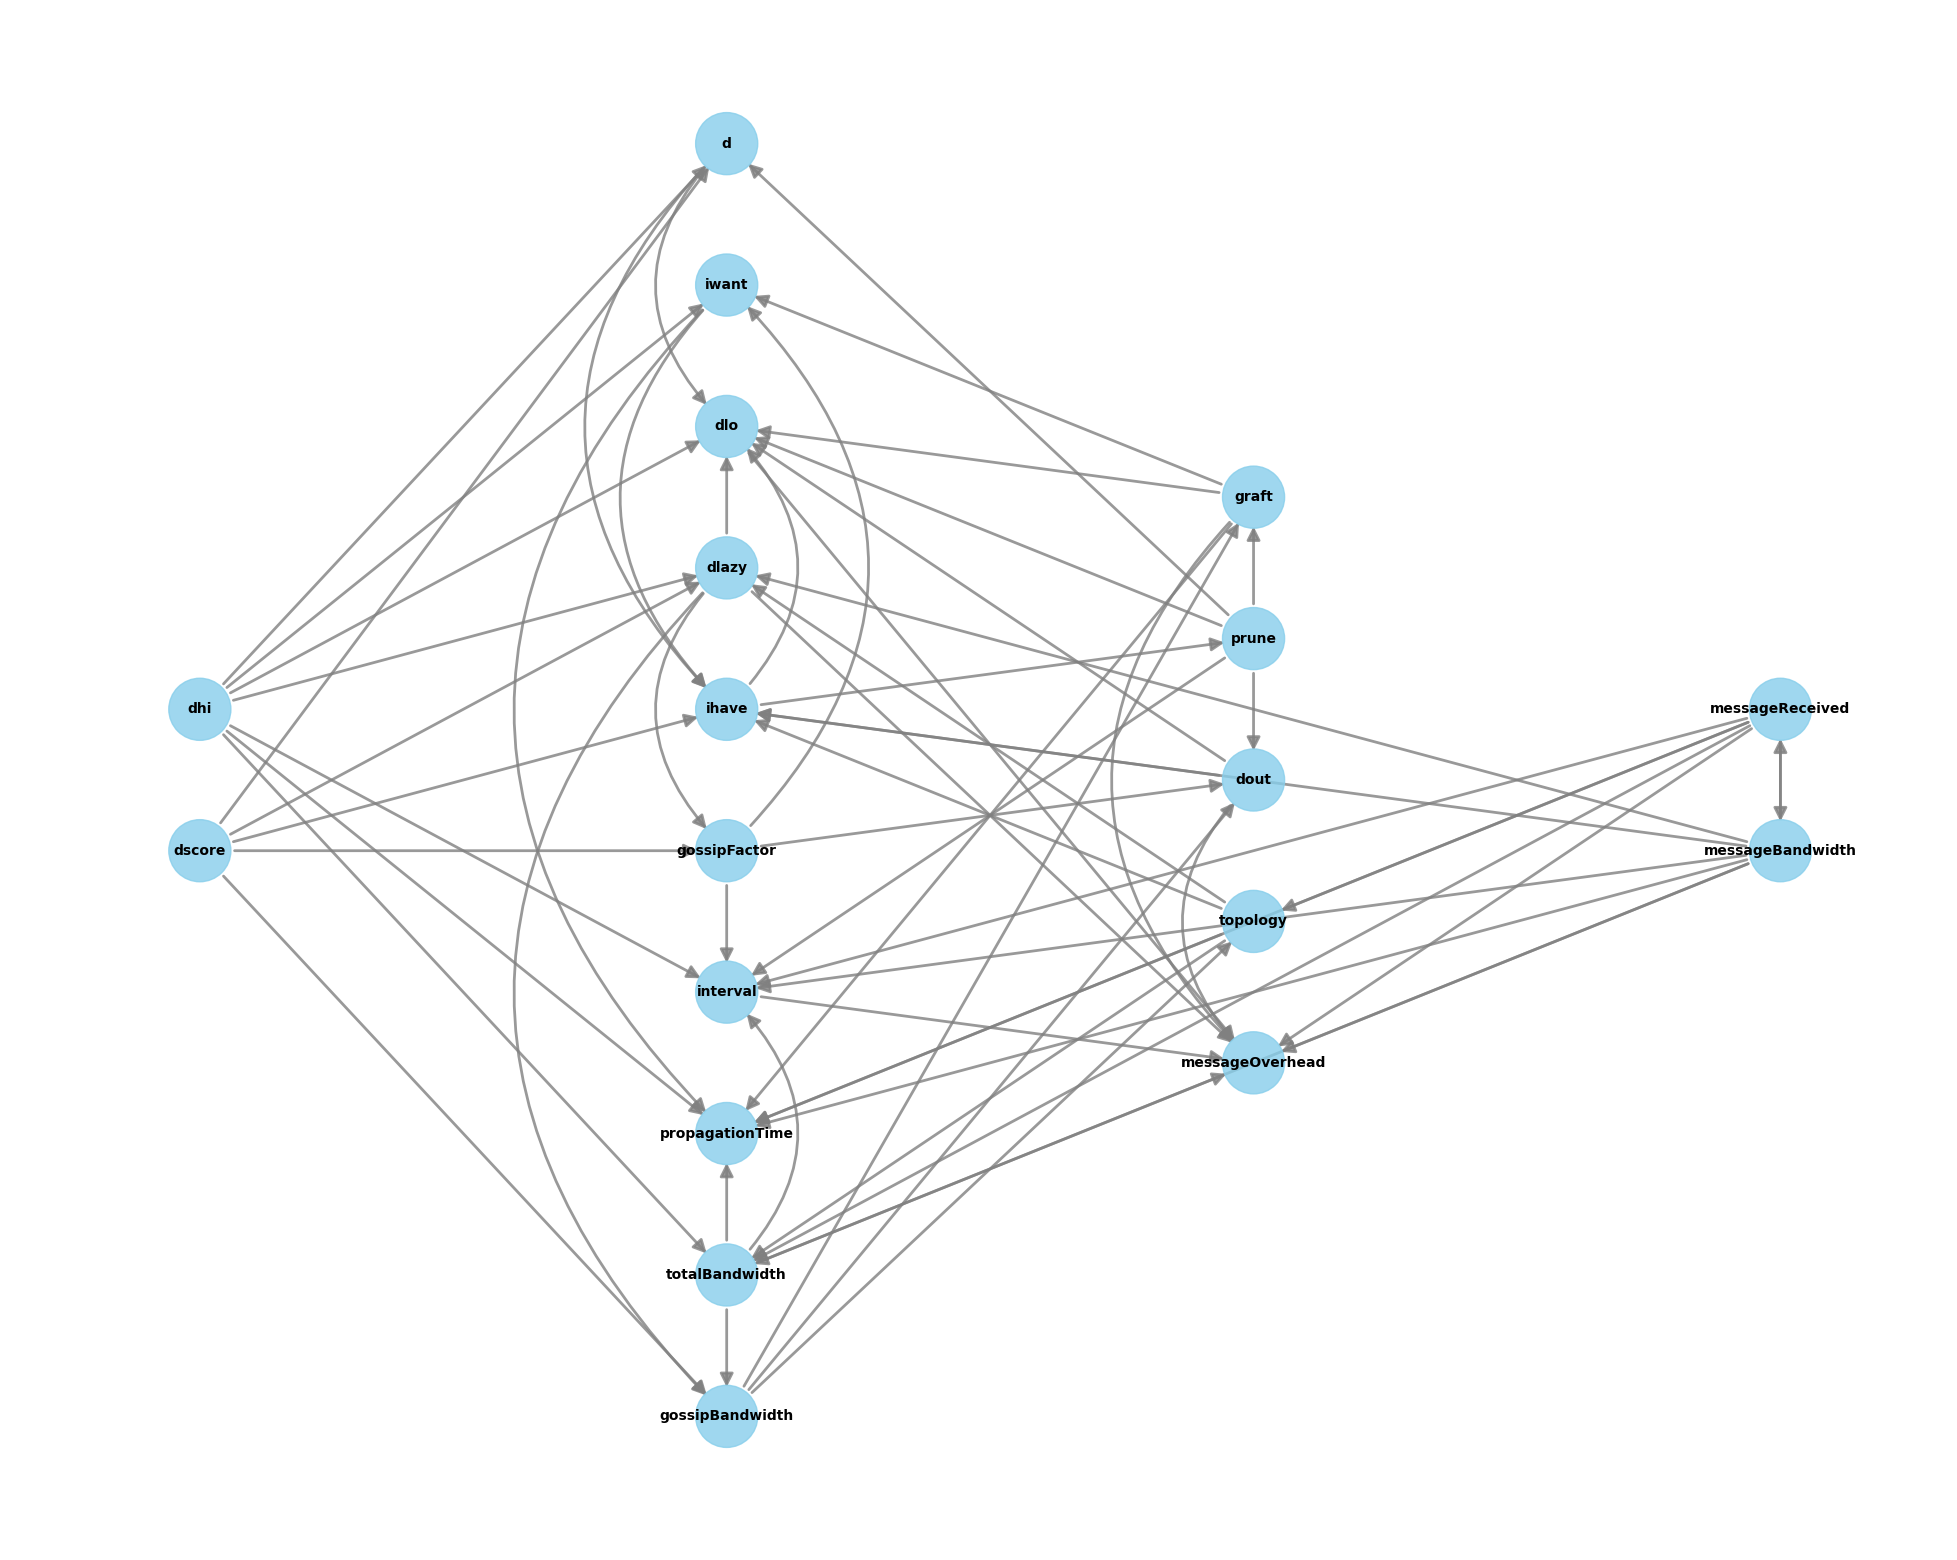

In [12]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [8]:
#Log normalization

# consolidateddiff = consolidated.diff().dropna()
consolidatedLog = consolidated

consolidatedLog['messageReceived'] = np.log(consolidated['messageReceived']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['graft'] = np.log(consolidated['graft']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['prune'] = np.log(consolidated['prune']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['iwant'] = np.log(consolidated['iwant']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['ihave'] = np.log(consolidated['ihave']).replace([np.inf, -np.inf], np.nan)
# consolidatedLog['gossipFactor'] = np.log10(consolidated['gossipFactor'])
consolidatedLog['propagationTime'] = np.log(consolidated['propagationTime']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['messageOverhead'] = np.log(consolidated['messageOverhead']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['totalBandiwdth'] = np.log(consolidated['totalBandwidth']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['gossipBandwidth'] = np.log(consolidated['gossipBandwidth']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['messageBandwidth'] = np.log(consolidated['messageBandwidth']).replace([np.inf, -np.inf], np.nan)

consolidatedLog = consolidatedLog.fillna(0)

X = consolidatedLog[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidatedLog.head(10)


/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology,totalBandiwdth
0,7.526581,8.228978,6.253829,0.0,0.0,0.000000,0.000000,4.646312,1702.4,6.743588,8,6,12,4,8,2,0.25,1.0,0,7.439794
1,7.451650,8.504311,6.511745,0.0,0.0,0.000000,6.548219,4.909709,2304.0,7.074286,8,6,12,4,8,2,0.25,1.0,0,7.742402
2,7.484366,9.042750,7.052721,0.0,0.0,0.000000,6.535241,5.445012,3896.8,7.587716,8,6,12,4,8,2,0.25,1.0,0,8.267911
3,7.765259,8.946505,6.939254,0.0,0.0,0.000000,5.837730,5.339459,3514.6,7.478735,8,6,12,4,8,2,0.25,1.0,0,8.164681
4,7.484072,8.678291,6.679599,0.0,0.0,0.000000,6.543912,5.077671,2726.0,7.237634,8,6,12,4,8,2,0.25,1.0,0,7.910591
5,7.475151,8.963800,6.982863,0.0,0.0,0.000000,6.467699,5.375278,3610.0,7.512618,8,6,12,4,8,2,0.25,1.0,0,8.191463
6,7.537324,8.810758,6.833032,0.0,0.0,0.000000,5.780744,5.227895,3074.4,7.343944,8,6,12,4,8,2,0.25,1.0,0,8.030865
7,7.416506,8.859931,6.877296,0.0,0.0,0.000000,6.459904,5.275049,3255.2,7.409136,8,6,12,4,8,2,0.25,1.0,0,8.088009
8,7.577462,8.989569,7.007601,0.0,0.0,0.693147,6.473891,5.399971,3700.4,7.536471,8,6,12,4,8,2,0.25,1.0,0,8.216196
9,7.584439,8.695172,6.715383,0.0,0.0,0.000000,5.768321,5.110782,2744.4,7.232589,8,6,12,4,8,2,0.25,1.0,0,7.917318


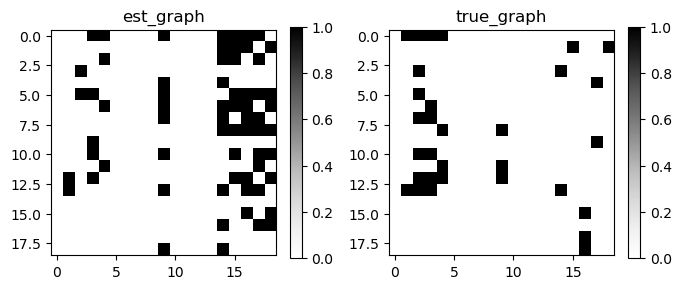

{'fdr': 0.8154, 'tpr': 0.3871, 'fpr': 0.3786, 'shd': 70, 'nnz': 65, 'precision': 0.1846, 'recall': 0.3871, 'F1': 0.25, 'gscore': 0.0}


In [9]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
                            (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
                            (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
                            (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
                            (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
                            (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
                            (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
                            (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
                            (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
                            (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15)])#,(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

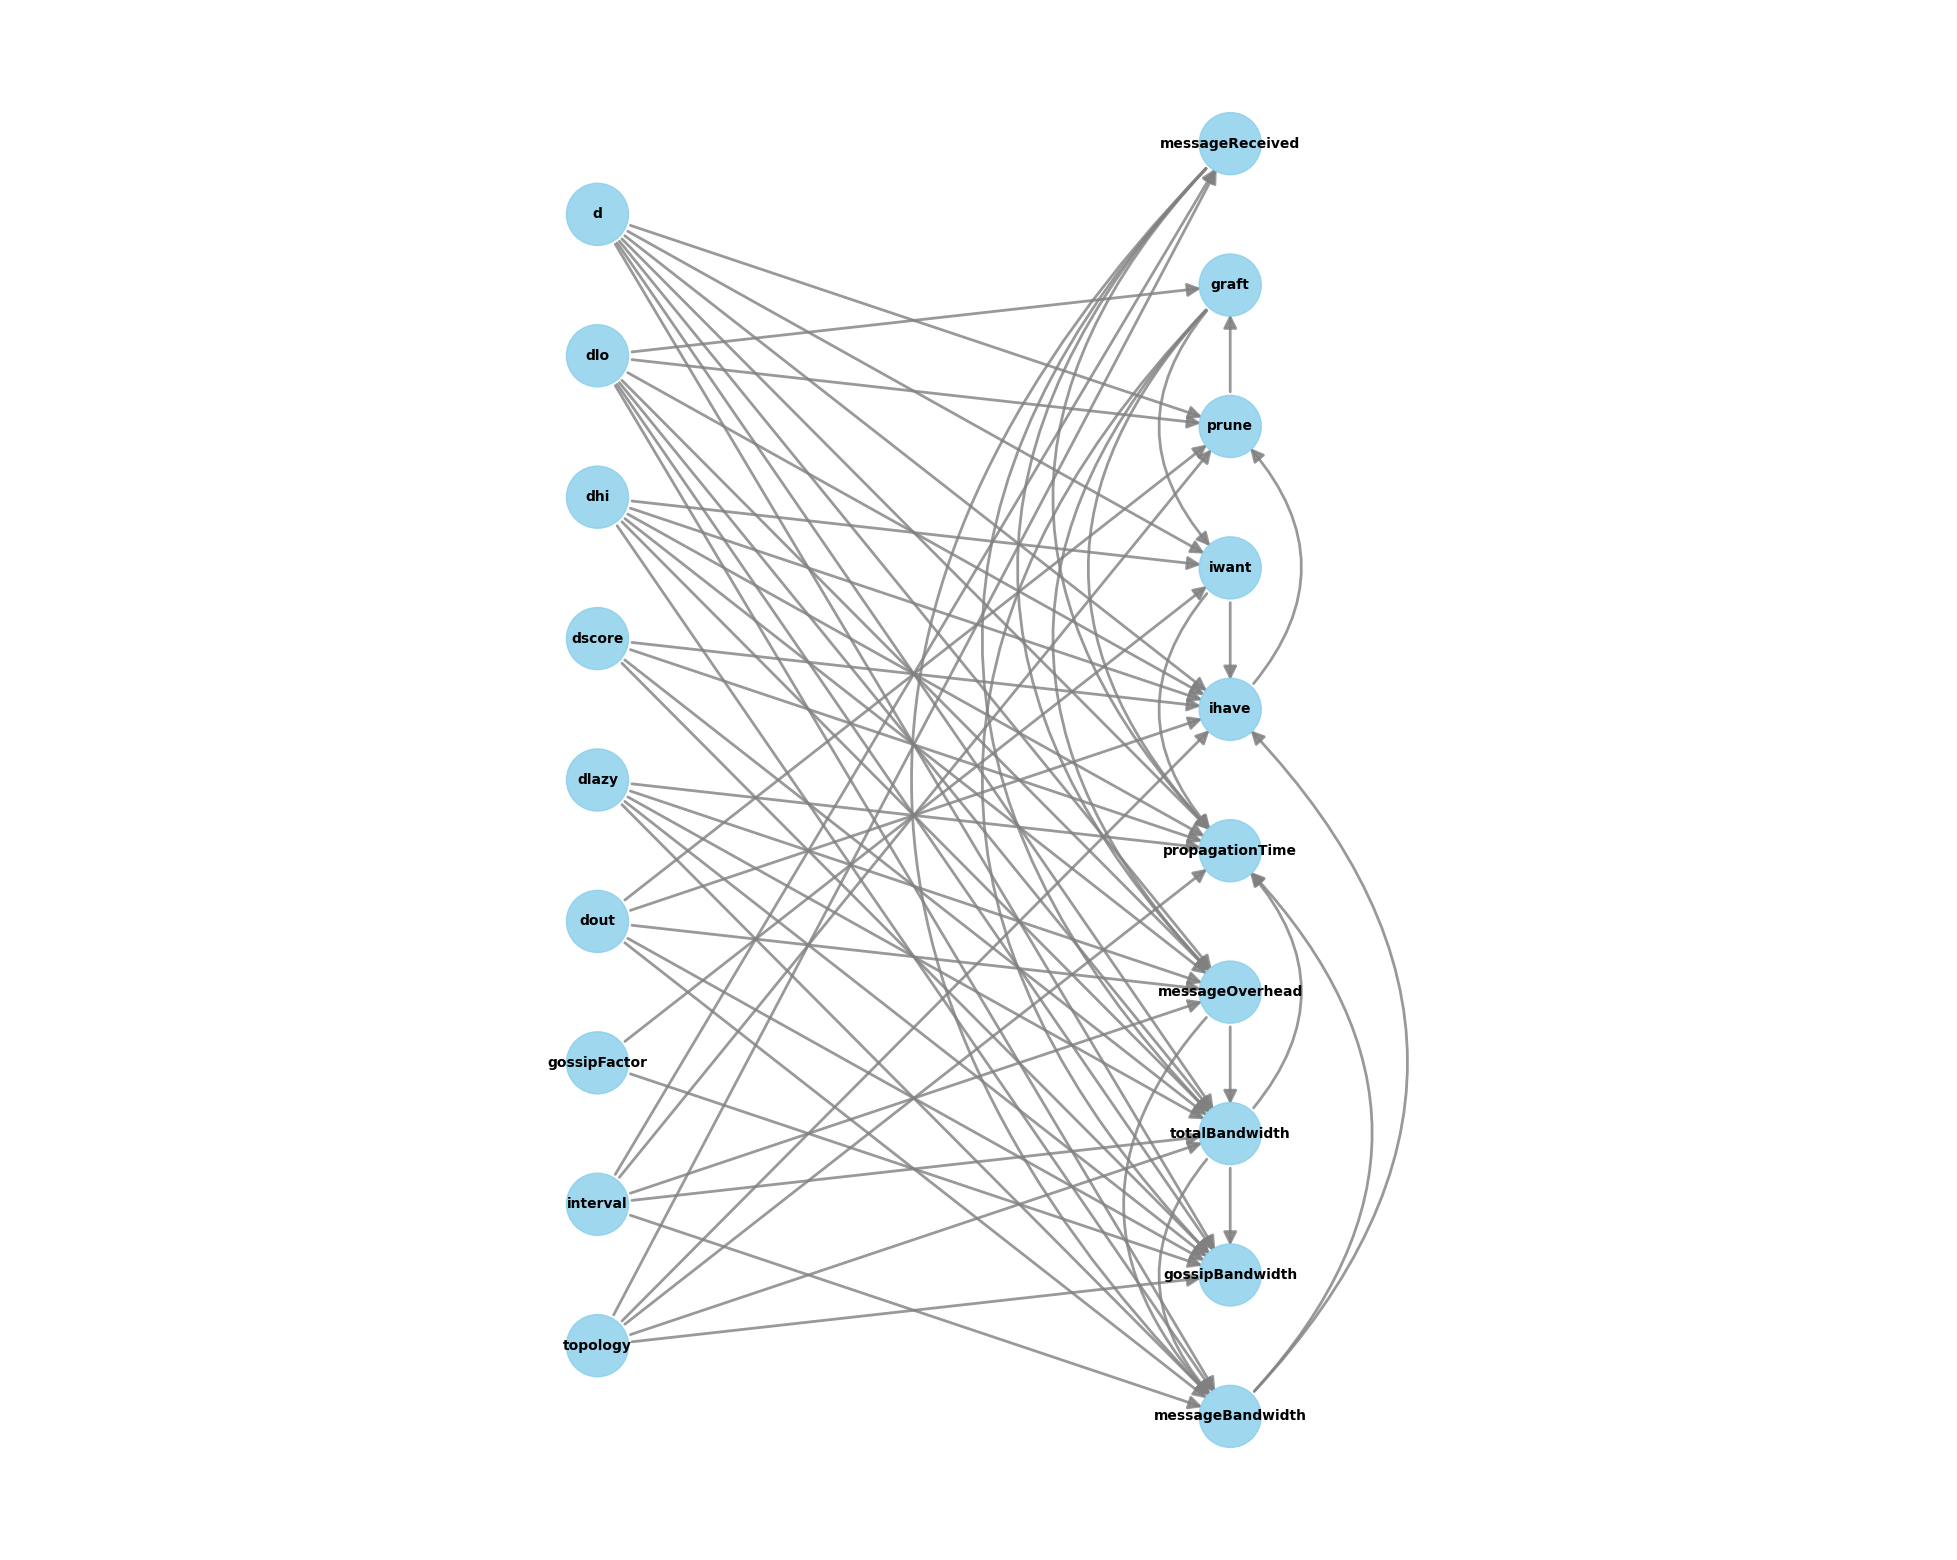

In [10]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab